In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import copy
from scipy.stats import ttest_ind, mannwhitneyu

In [3]:
def preprocessingI(df: pd.DataFrame):
    df['category'].replace({'Кошки': 0, 'Собаки': 1}, inplace=True)
    df['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
    df['gender'].replace({'Ж': 0, 'М': 1}, inplace=True)

    return copy(df)


def preprocessingII(df: pd.DataFrame):
    # Функция для выявления выбросов
    def detect_outliers_iqr(df):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df >= lower_bound) & (df <= upper_bound)]

    # Применение функции к столбцам, где могут быть выбросы
    df['price'] = detect_outliers_iqr(df['price'])
    df['page_views'] = detect_outliers_iqr(df['page_views'])
    df['contacts'] = detect_outliers_iqr(df['contacts'])

    # Заполнение пропусков в числовых столбцах средним значением
    df['seller_rating'].fillna(df['seller_rating'].mean(), inplace=True)

    # Заполнение пропусков в категориальных столбцах модой
    df['breed'].fillna(df['breed'].mode()[0], inplace=True)

    # Заполнение пропусков вперед
    df['seller_count_reviews'].fillna(method='ffill', inplace=True)

    # Заполнение пропусков назад
    df['page_views'].fillna(df['page_views'].median(), inplace=True)
    df['contacts'].fillna(df['contacts'].median(), inplace=True)
    df['favorites'].fillna(df['favorites'].median(), inplace=True)

    return copy(df)

file_path = 'data//avito_new_data_for_dano.xlsx'
data = pd.read_excel(file_path)
data_start = pd.read_excel(file_path)
data_start = preprocessingI(data_start)
data = preprocessingII(preprocessingI(data_start))

C:\Users\npred\AppData\Local\Temp\ipykernel_15816\4049658517.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category'].replace({'Кошки': 0, 'Собаки': 1}, inplace=True)
C:\Users\npred\AppData\Local\Temp\ipykernel_15816\4049658517.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['catego

In [4]:
data['liquidity'] = data['page_views'] + data['contacts'] + data['favorites']
data['cr'] = data['contacts'] / data['page_views']
data_start['liquidity'] = data_start['page_views'] + data_start['contacts'] + data_start['favorites']
data_start['cr'] = data_start['contacts'] / data_start['page_views']

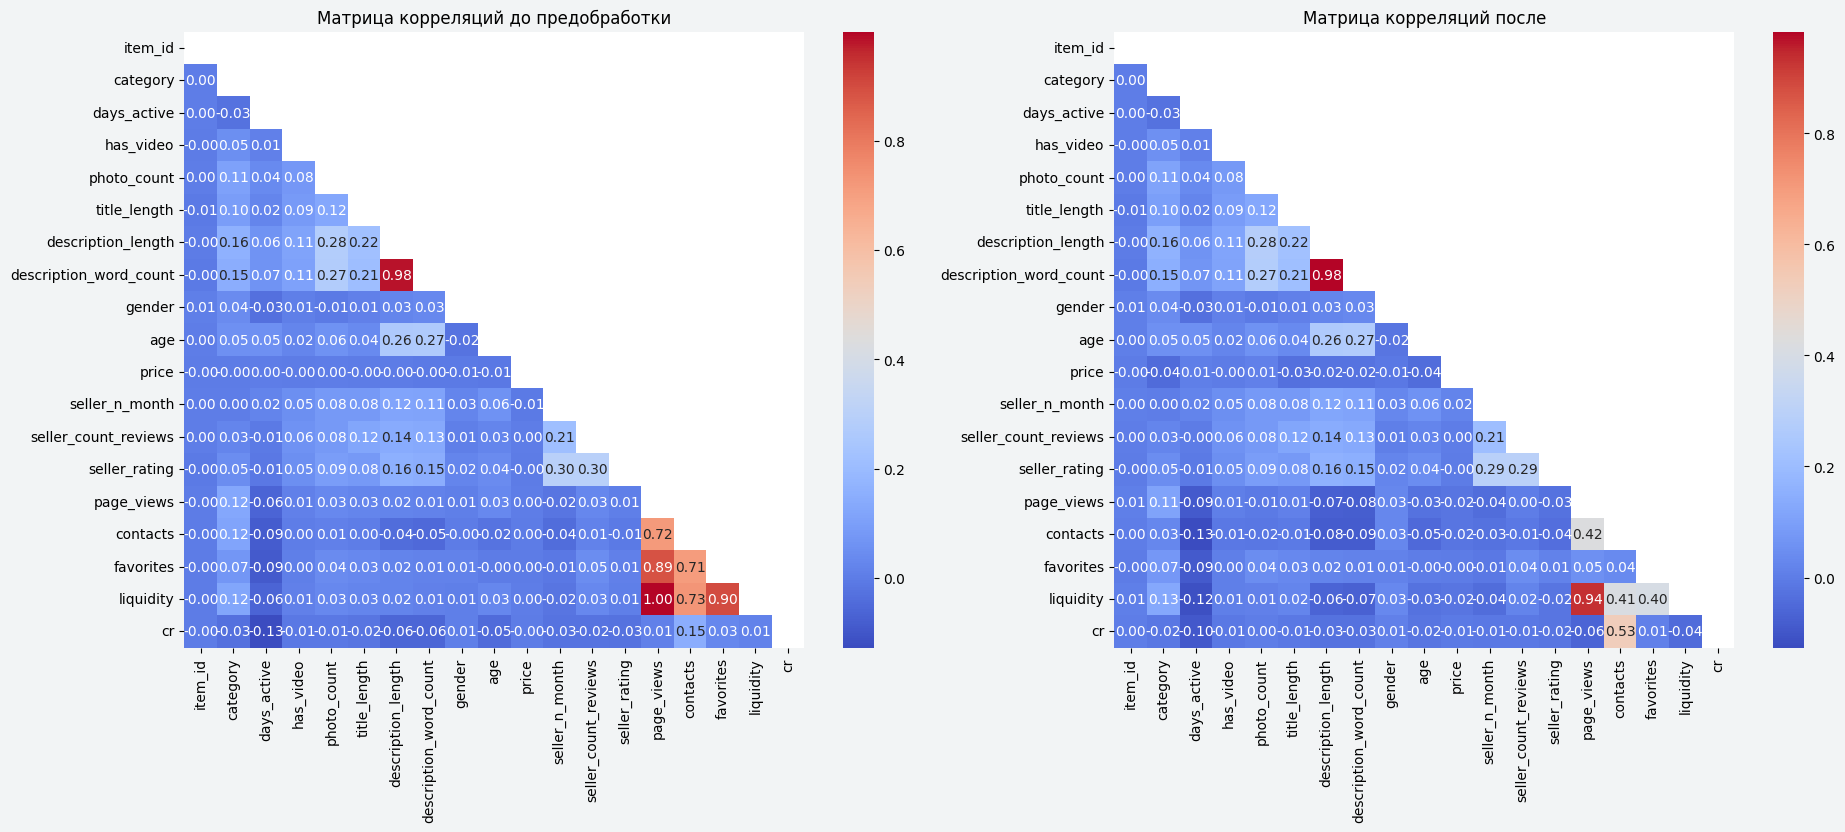

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))

correlation_matrixI = data_start.drop(columns=['title', 'DescriptionRu', 'breed']).corr()
mask = np.triu(np.ones_like(correlation_matrixI, dtype=bool))
correlation_matrixI = correlation_matrixI.mask(mask)

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrixI, annot=True, cmap='coolwarm', fmt='.2f', ax=axs[0])
axs[0].set_title('Матрица корреляций до предобработки')

correlation_matrix = data.drop(columns=['title', 'DescriptionRu', 'breed']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix = correlation_matrix.mask(mask)

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axs[1])
axs[1].set_title('Матрица корреляций после')
fig.patch.set_facecolor('#f2f4f5')

plt.show()

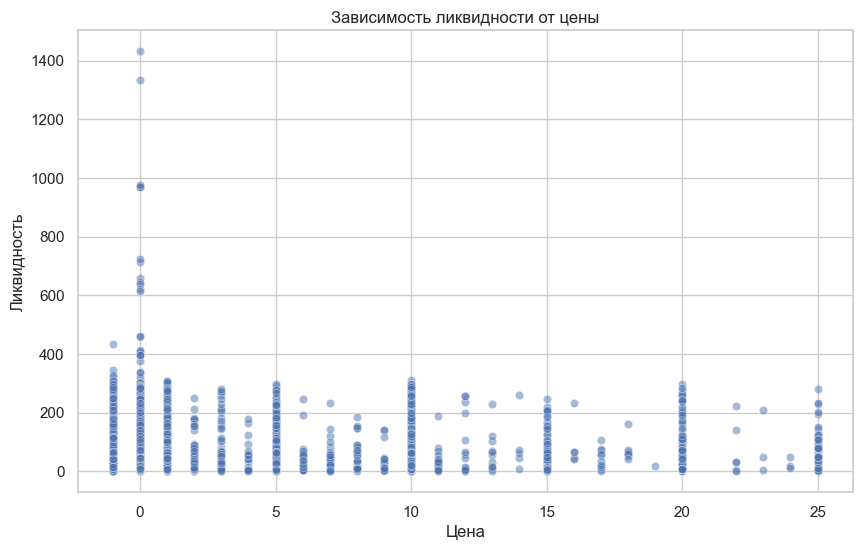

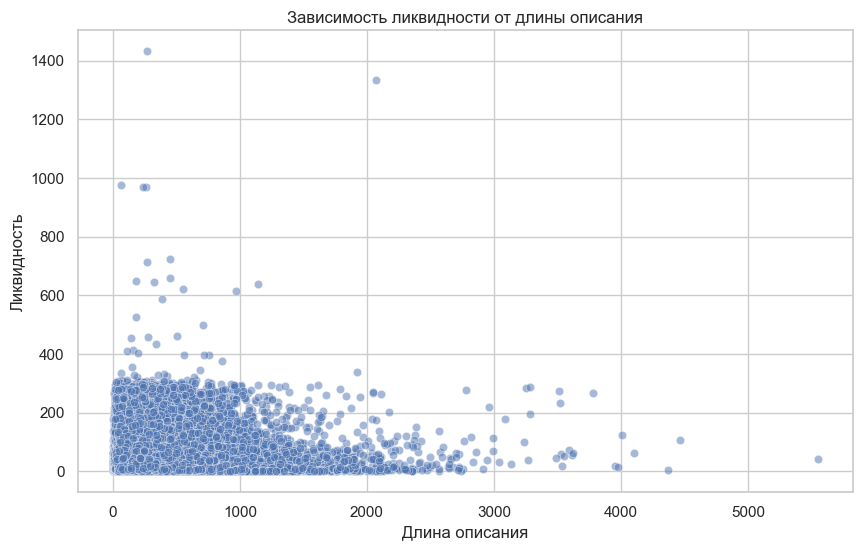

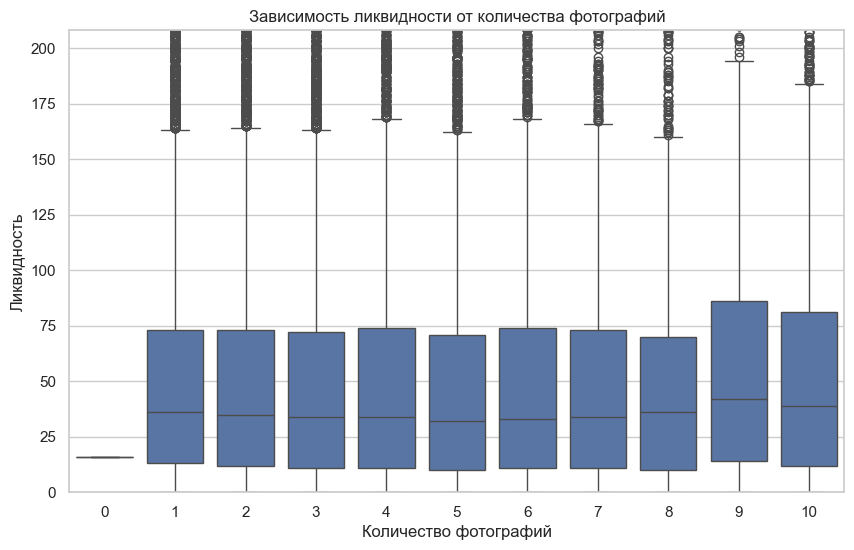

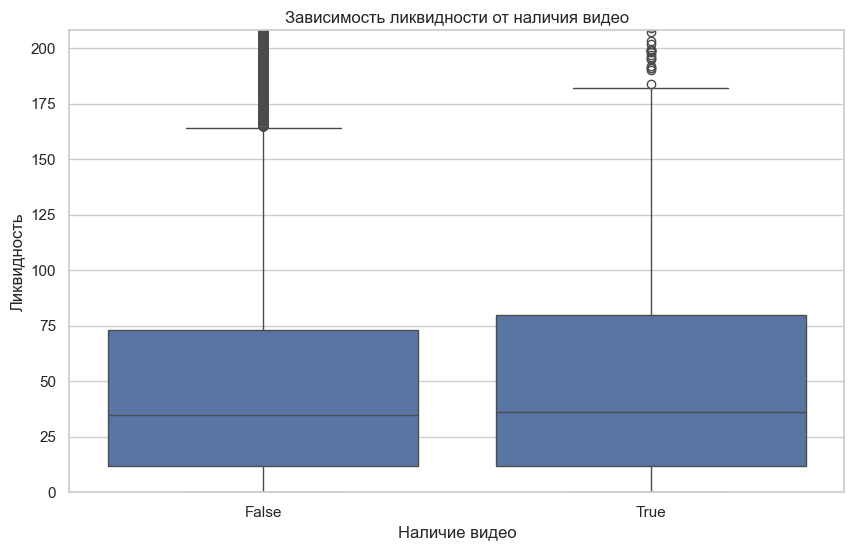

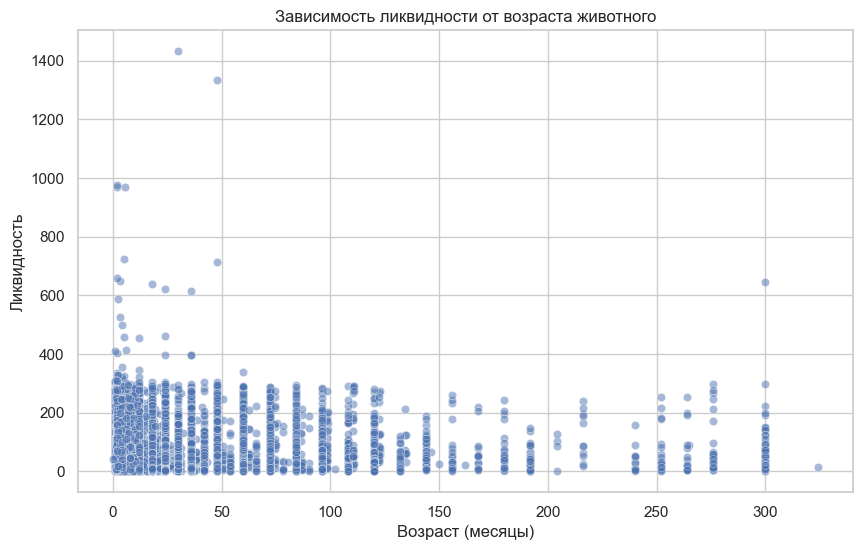

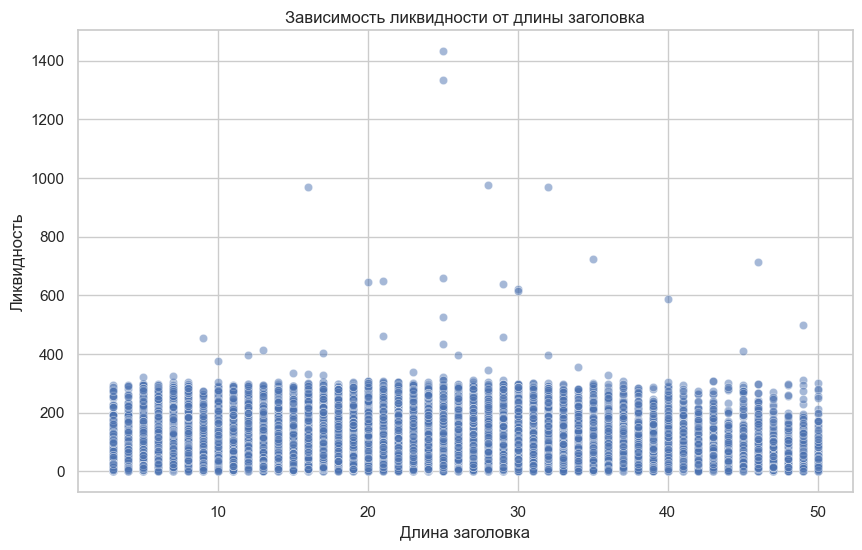

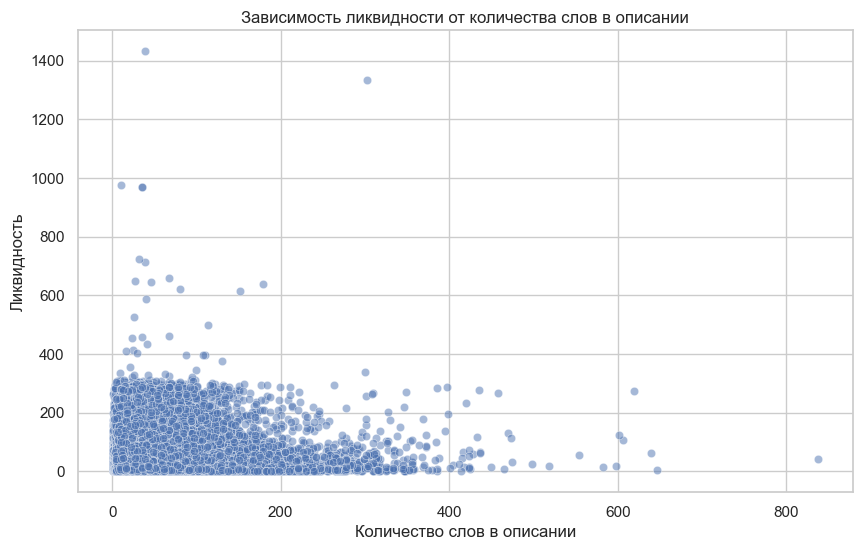

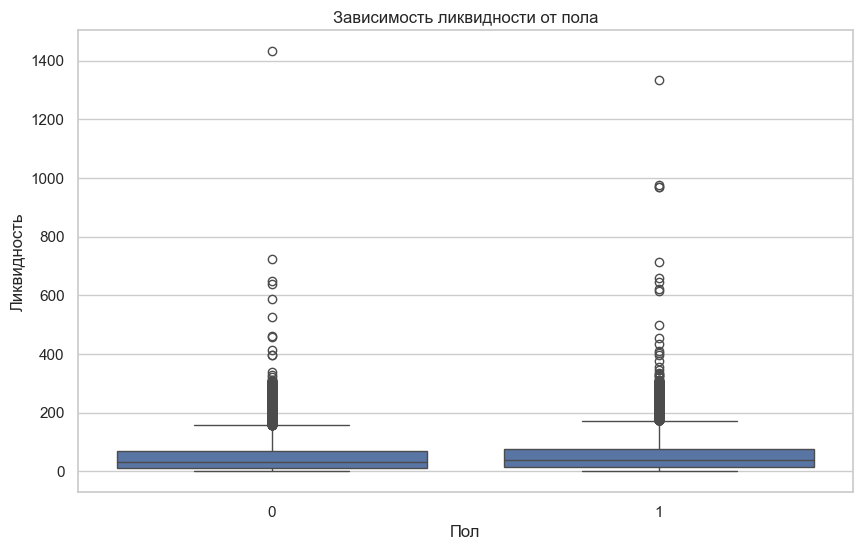

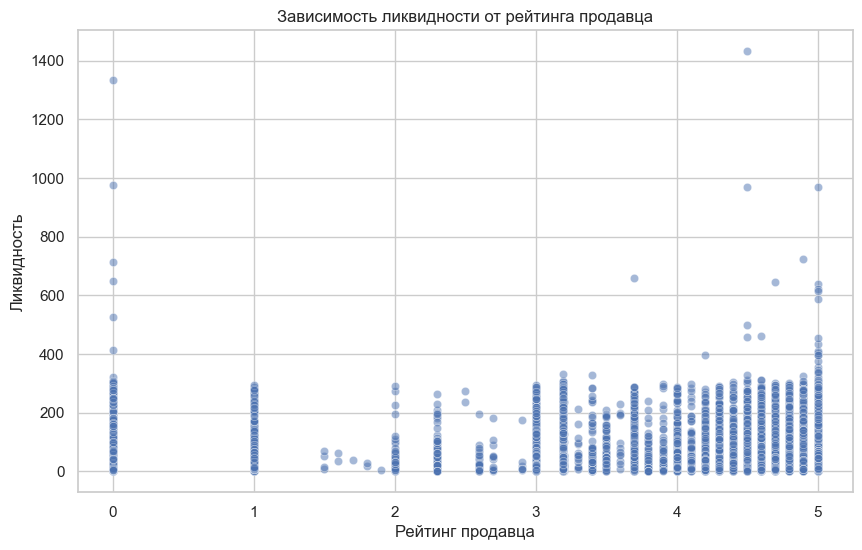

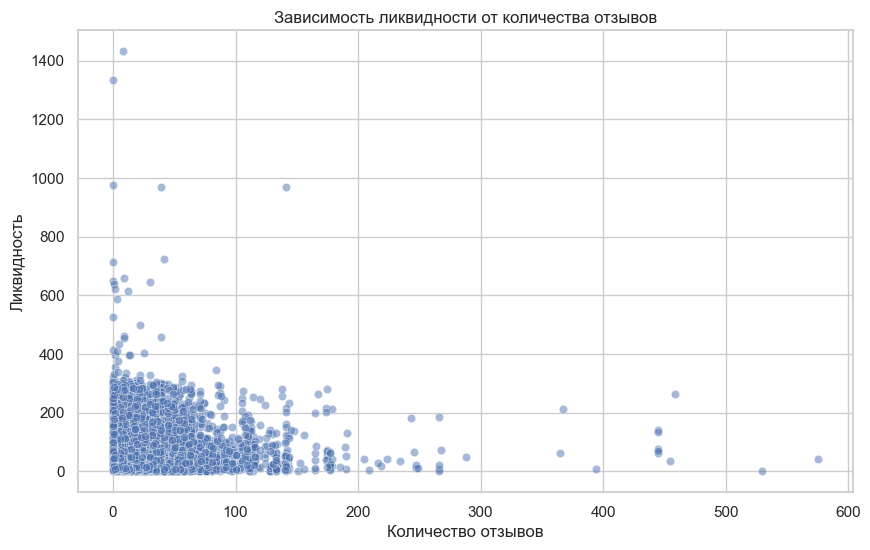

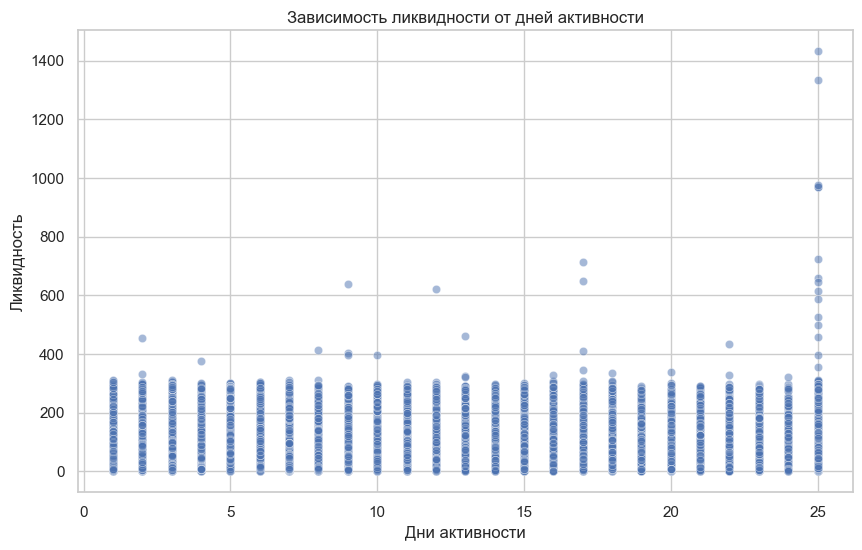

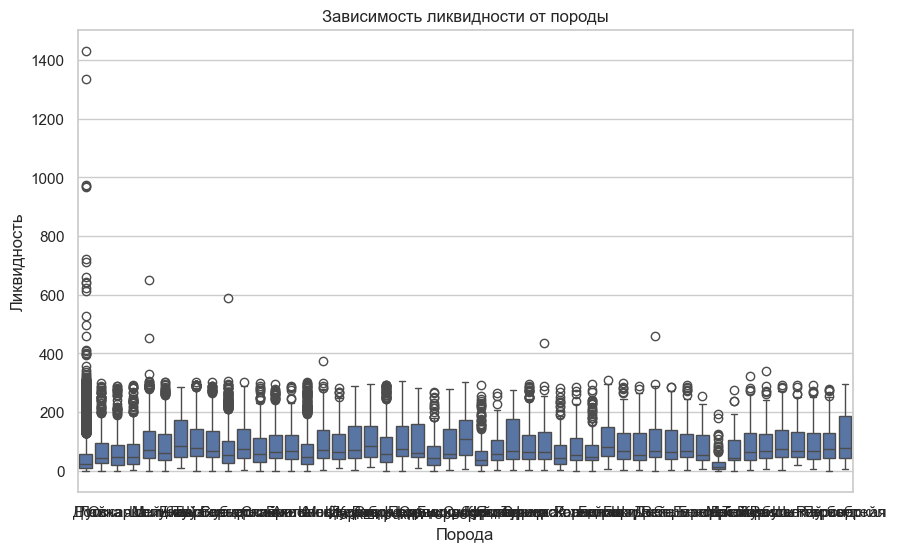

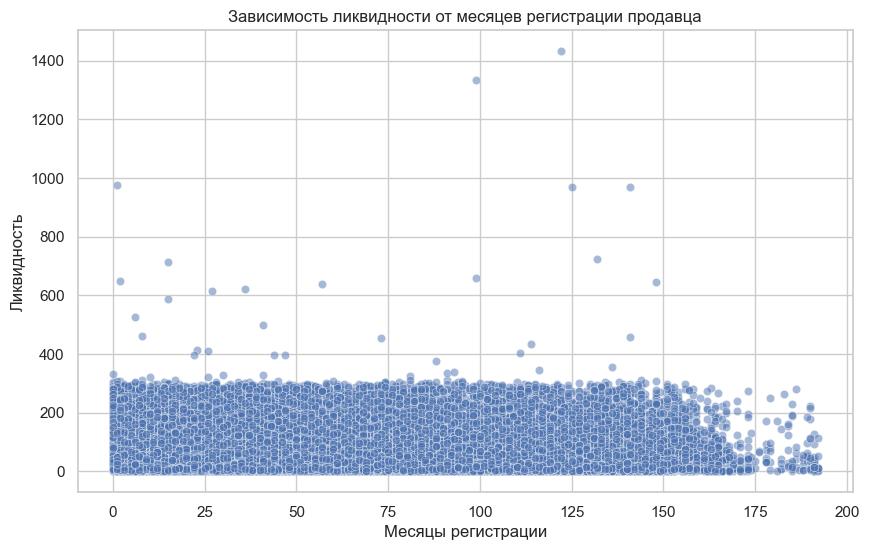

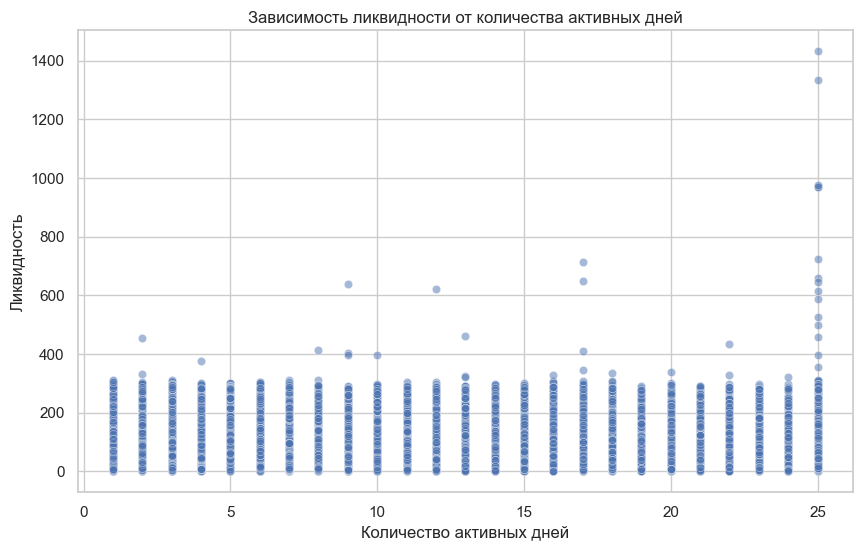

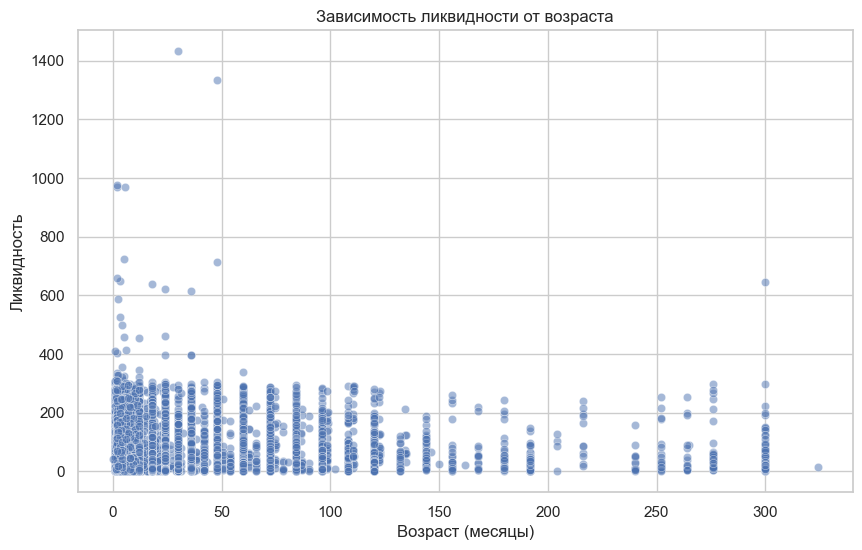

In [57]:
df = data

# Настройка стиля графиков
sns.set(style="whitegrid")

# Функция для построения графиков с KDE
def plot_with_kde(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# 1. Зависимость ликвидности от цены
plot_with_kde('price', 'liquidity', 'Зависимость ликвидности от цены', 'Цена', 'Ликвидность')

# 2. Зависимость ликвидности от длины описания
plot_with_kde('description_length', 'liquidity', 'Зависимость ликвидности от длины описания', 'Длина описания', 'Ликвидность')

# 3. Зависимость ликвидности от количества фотографий
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='photo_count', y='liquidity')
plt.title('Зависимость ликвидности от количества фотографий')
plt.xlabel('Количество фотографий')
plt.ylabel('Ликвидность')
plt.ylim(0, df['liquidity'].quantile(0.95))  # Уменьшаем пределы
plt.show()

# 4. Зависимость ликвидности от наличия видео
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='has_video', y='liquidity')
plt.title('Зависимость ликвидности от наличия видео')
plt.xlabel('Наличие видео')
plt.ylabel('Ликвидность')
plt.ylim(0, df['liquidity'].quantile(0.95))  # Уменьшаем пределы
plt.show()

# 5. Зависимость ликвидности от возраста животного
plot_with_kde('age', 'liquidity', 'Зависимость ликвидности от возраста животного', 'Возраст (месяцы)', 'Ликвидность')

# 6. Зависимость ликвидности от длины заголовка
plot_with_kde('title_length', 'liquidity', 'Зависимость ликвидности от длины заголовка', 'Длина заголовка', 'Ликвидность')

# 7. Зависимость ликвидности от количества слов в описании
plot_with_kde('description_word_count', 'liquidity', 'Зависимость ликвидности от количества слов в описании', 'Количество слов в описании', 'Ликвидность')

# 8. Зависимость ликвидности от пола
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='gender', y='liquidity')
plt.title('Зависимость ликвидности от пола')
plt.xlabel('Пол')
plt.ylabel('Ликвидность')
plt.show()

# 9. Зависимость ликвидности от рейтинга продавца
plot_with_kde('seller_rating', 'liquidity', 'Зависимость ликвидности от рейтинга продавца', 'Рейтинг продавца', 'Ликвидность')

# 10. Зависимость ликвидности от количества отзывов
plot_with_kde('seller_count_reviews', 'liquidity', 'Зависимость ликвидности от количества отзывов', 'Количество отзывов', 'Ликвидность')

# 11. Зависимость ликвидности от дней активности
plot_with_kde('days_active', 'liquidity', 'Зависимость ликвидности от дней активности', 'Дни активности', 'Ликвидность')

# 12. Зависимость ликвидности от породы
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='breed', y='liquidity')
plt.title('Зависимость ликвидности от породы')
plt.xlabel('Порода')
plt.ylabel('Ликвидность')
plt.show()

# 13. Зависимость ликвидности от количества дней с момента регистрации продавца
plot_with_kde('seller_n_month', 'liquidity', 'Зависимость ликвидности от месяцев регистрации продавца', 'Месяцы регистрации', 'Ликвидность')

# 14. Зависимость ликвидности от количества активных дней
plot_with_kde('days_active', 'liquidity', 'Зависимость ликвидности от количества активных дней', 'Количество активных дней', 'Ликвидность')

# 15. Зависимость ликвидности от возраста
plot_with_kde('age', 'liquidity', 'Зависимость ликвидности от возраста', 'Возраст (месяцы)', 'Ликвидность')

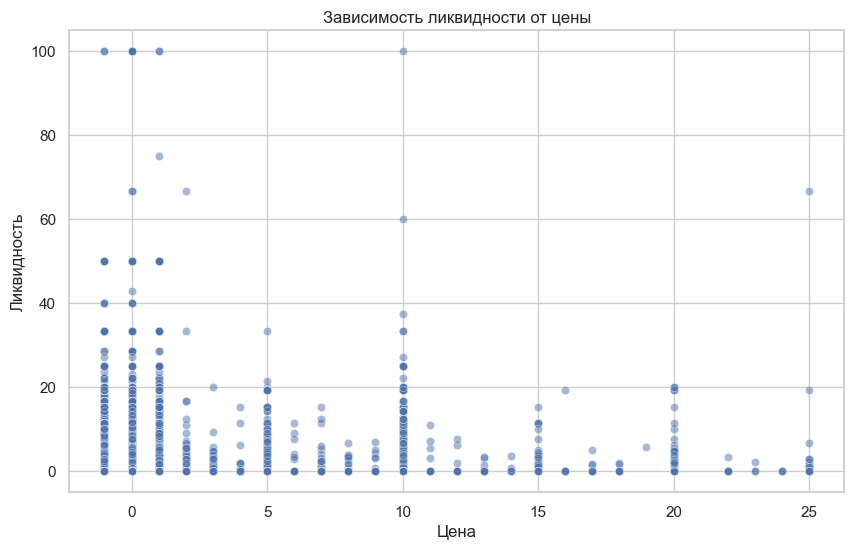

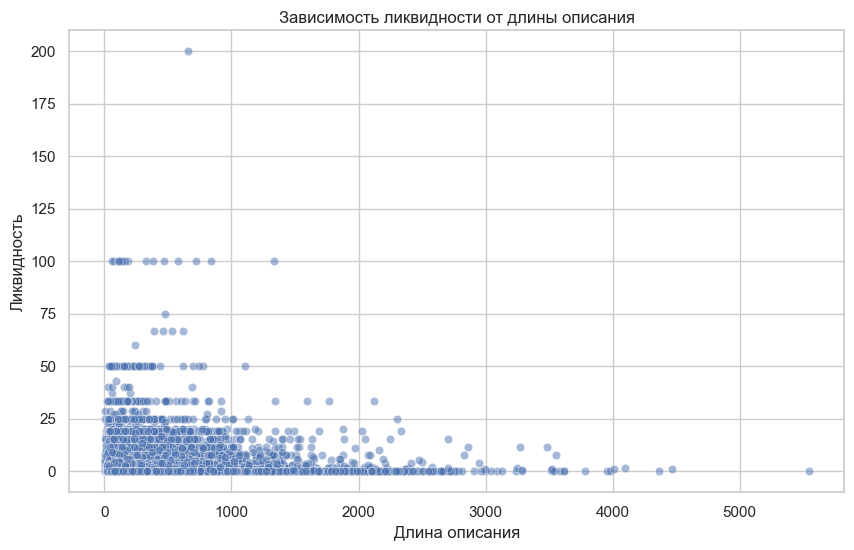

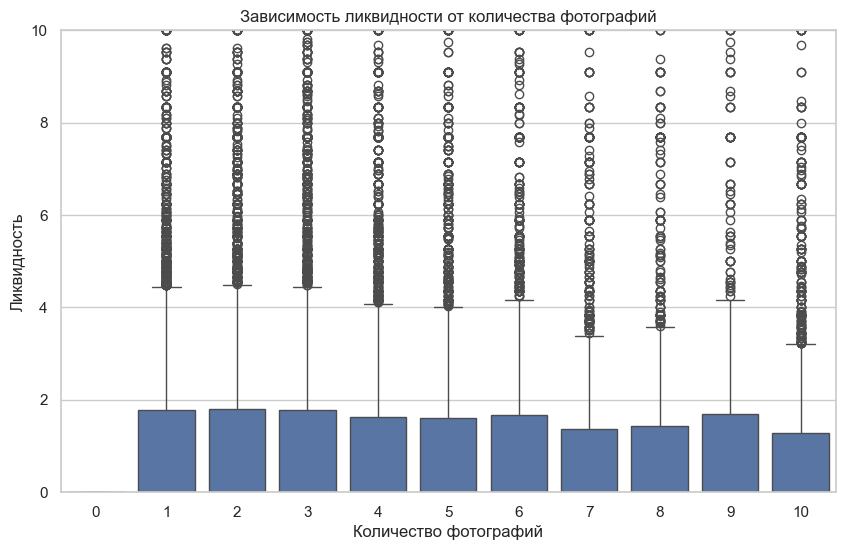

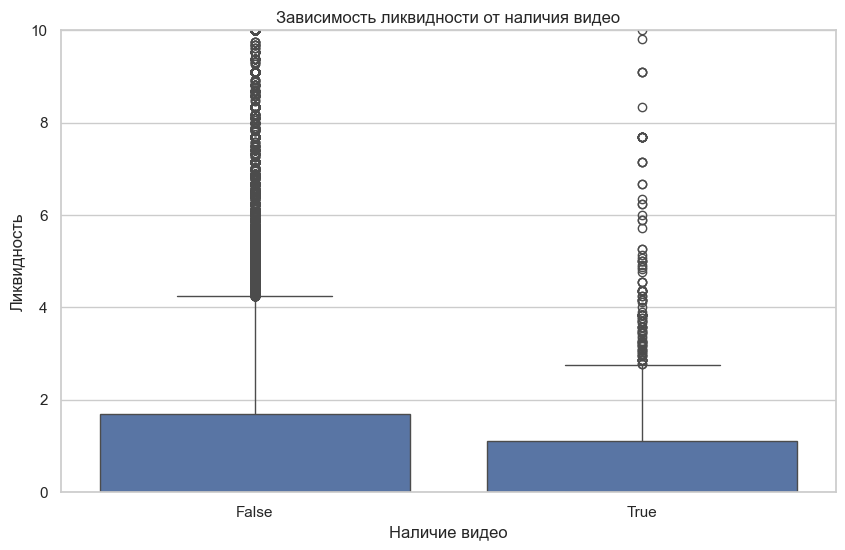

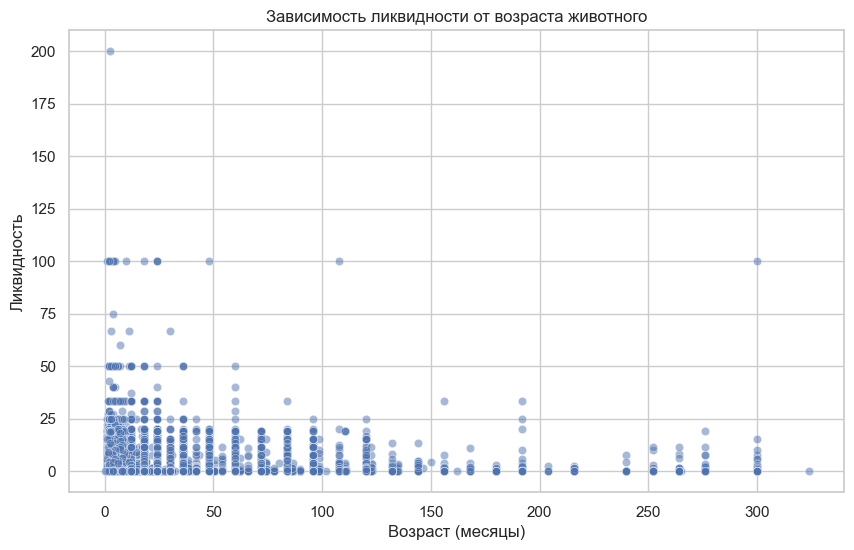

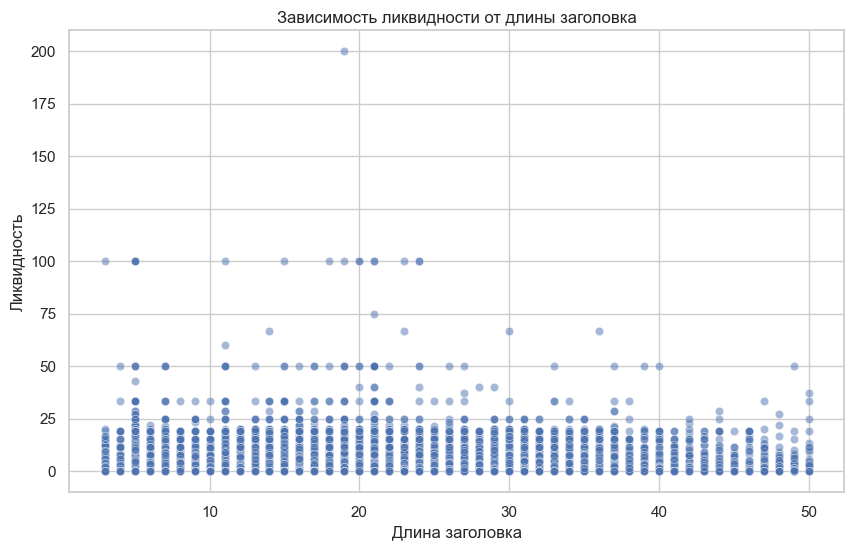

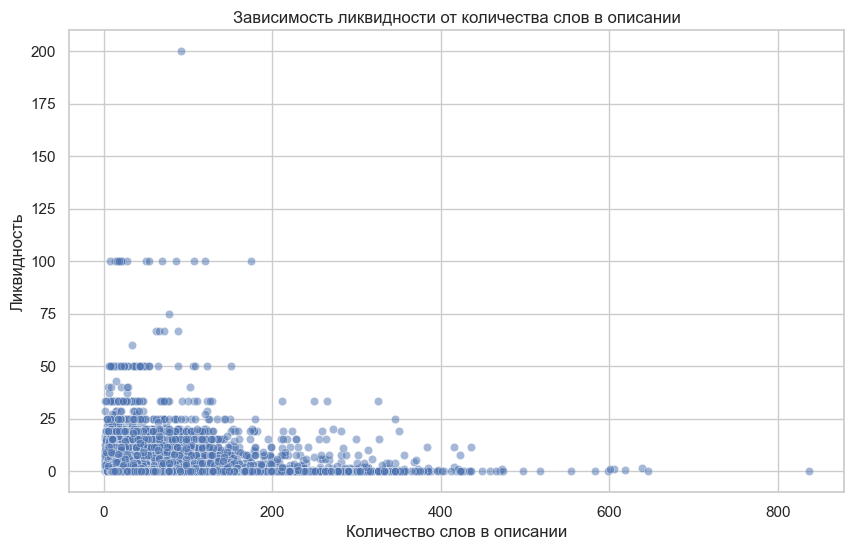

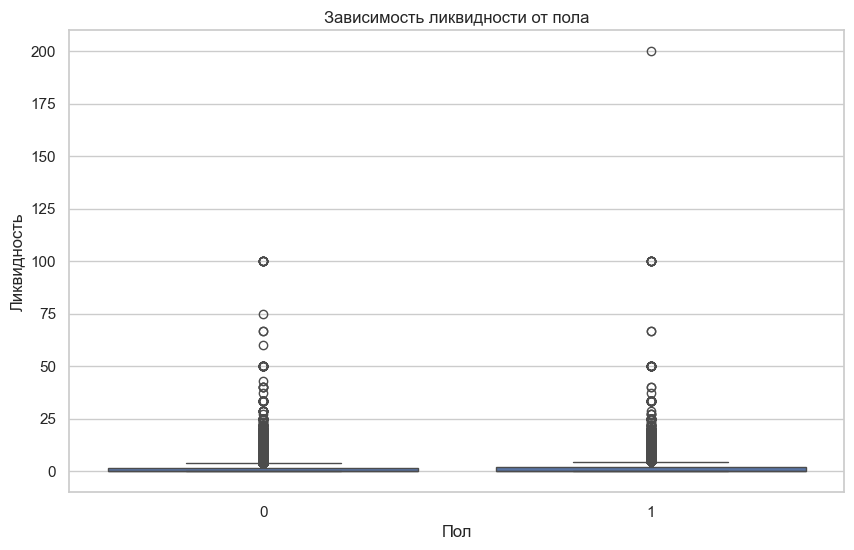

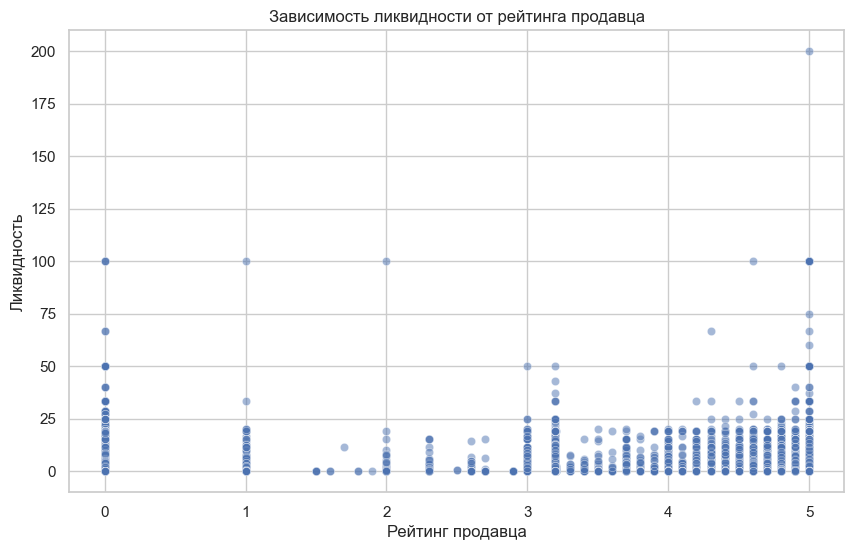

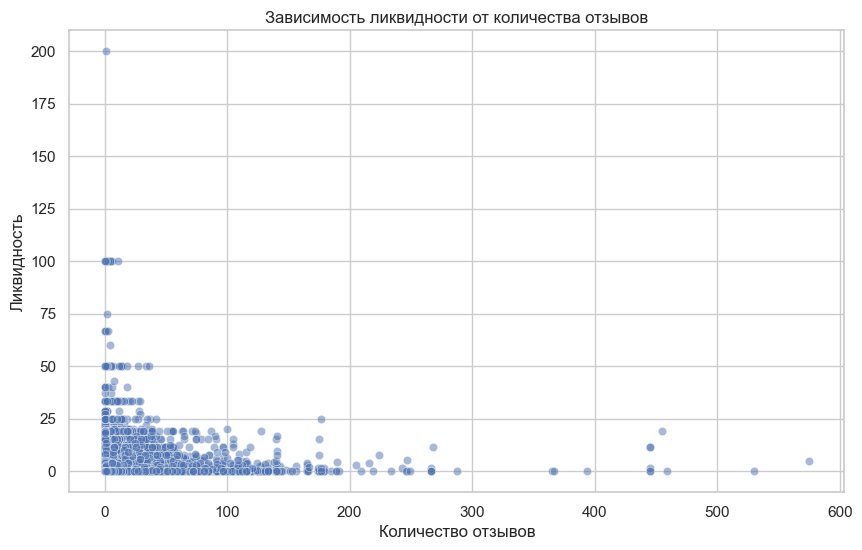

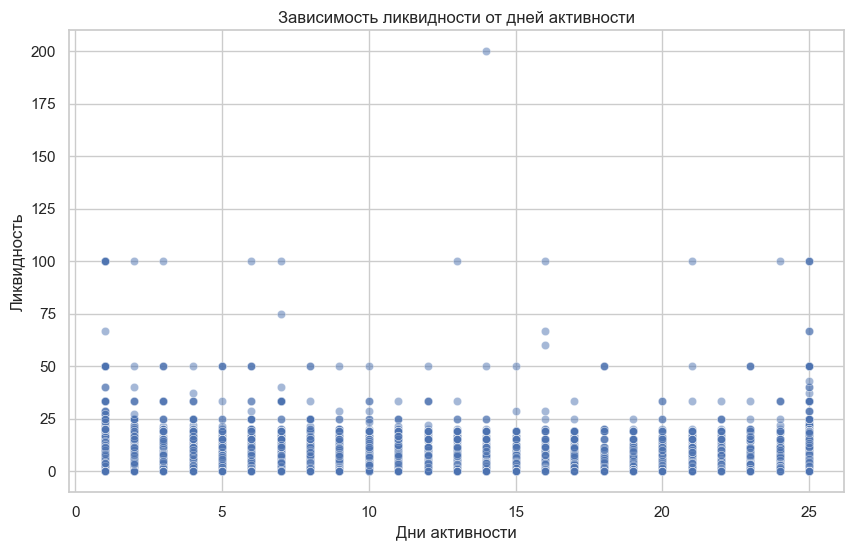

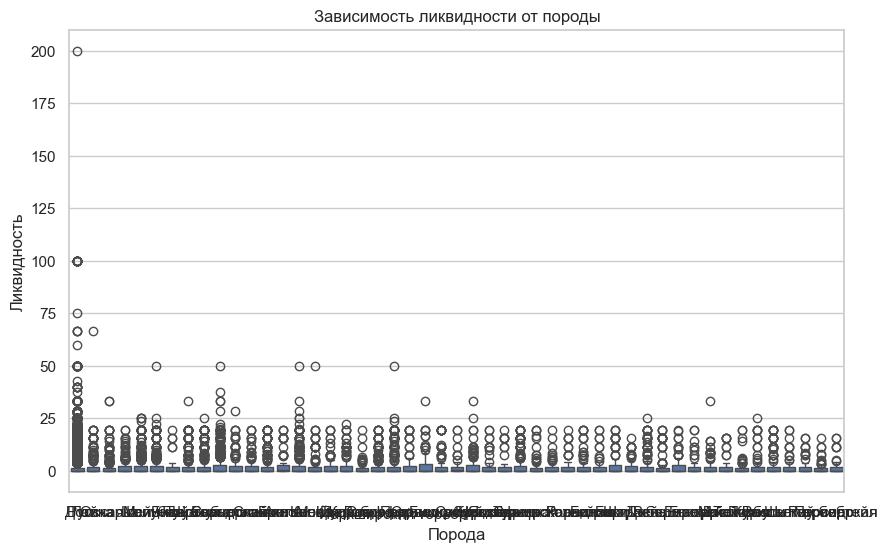

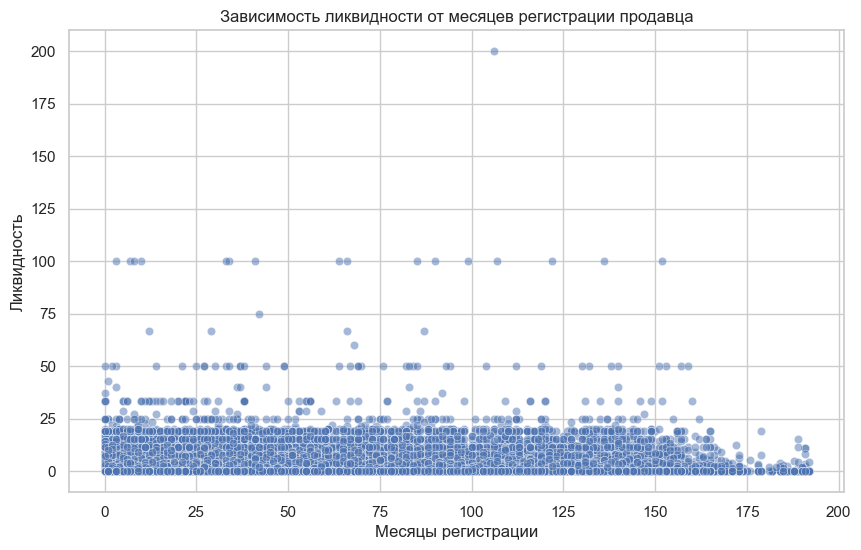

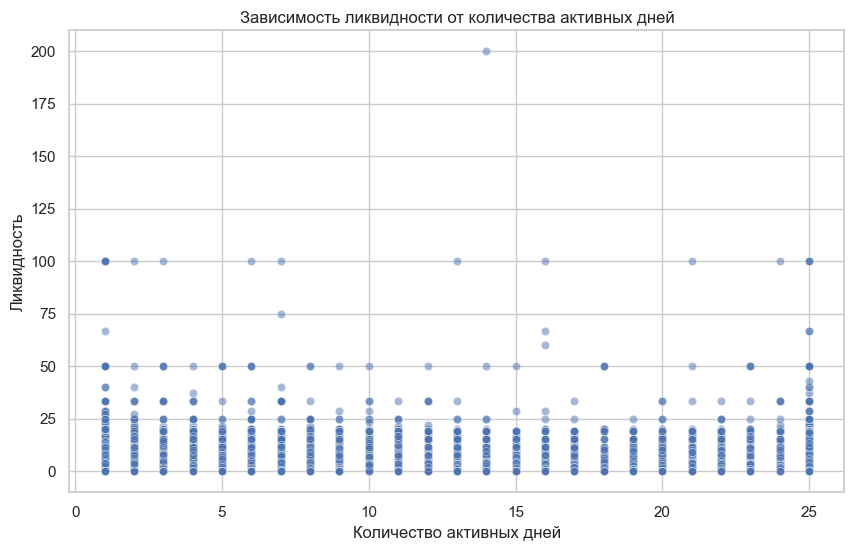

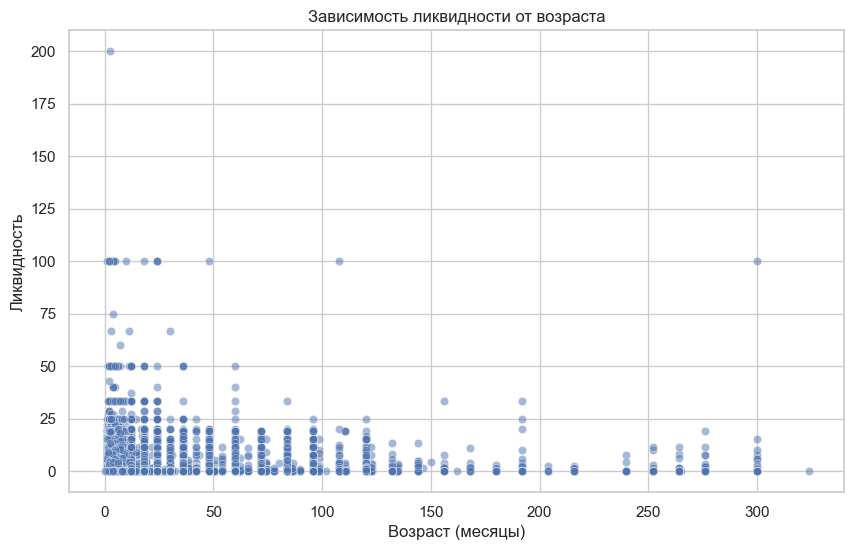

In [8]:
#f2f4f5

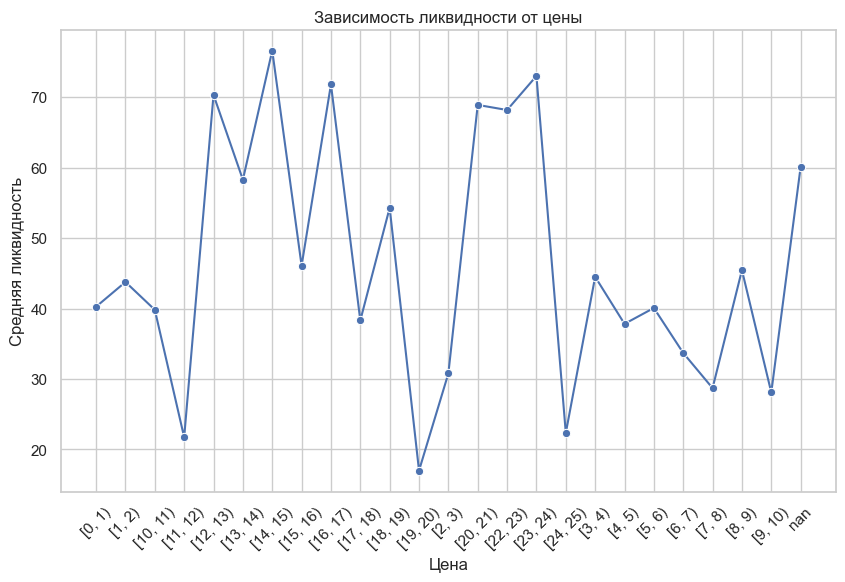

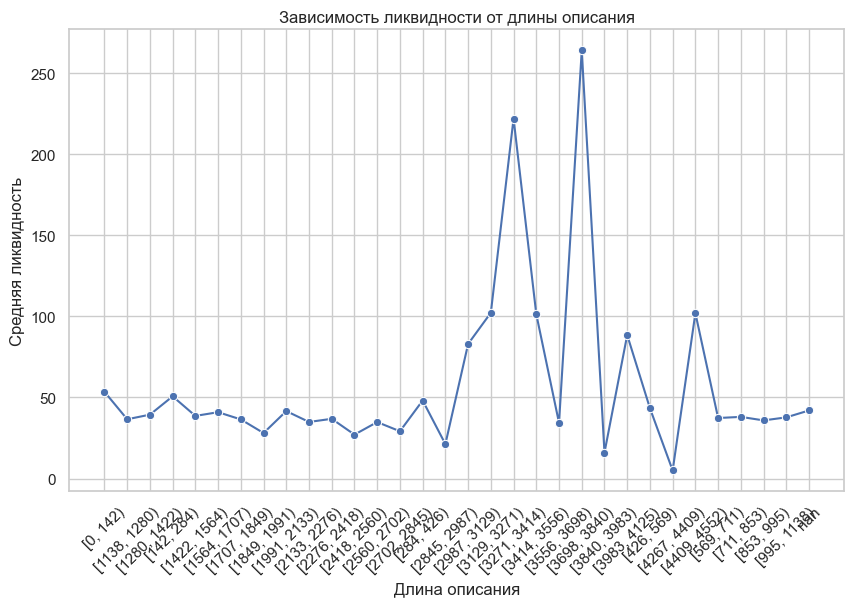

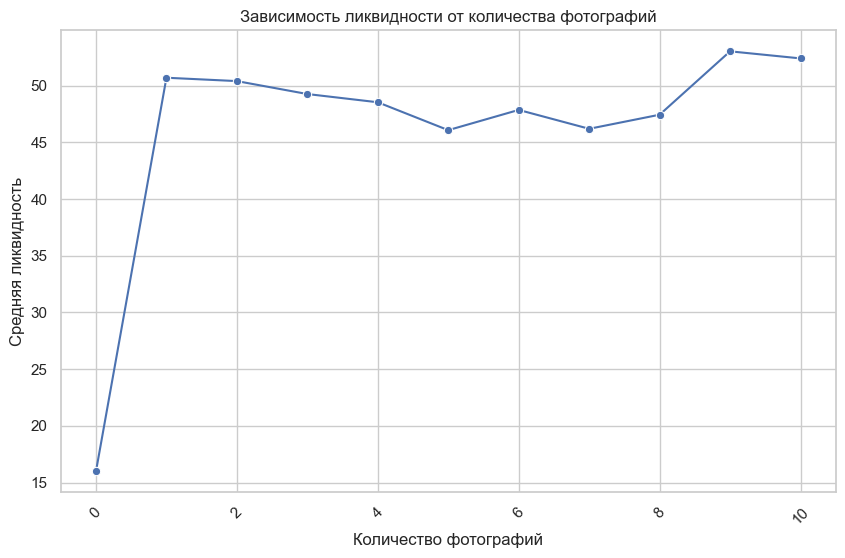

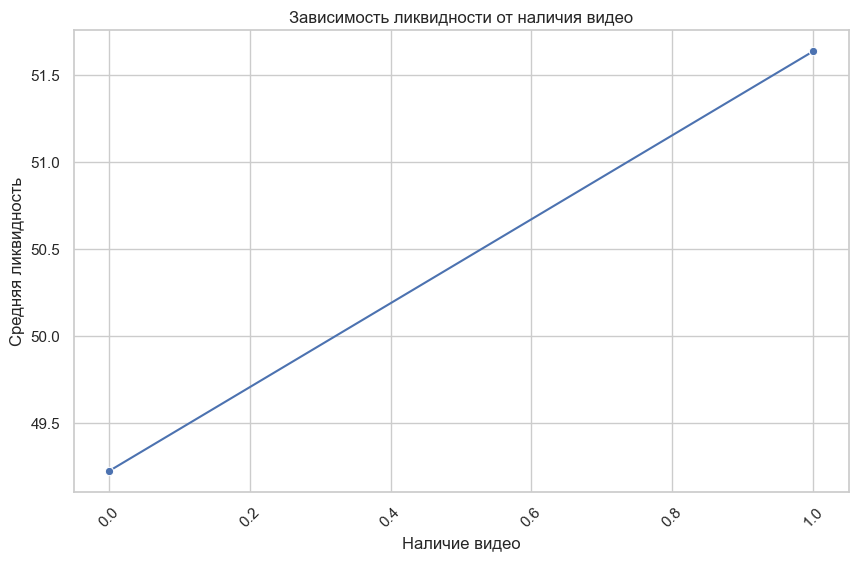

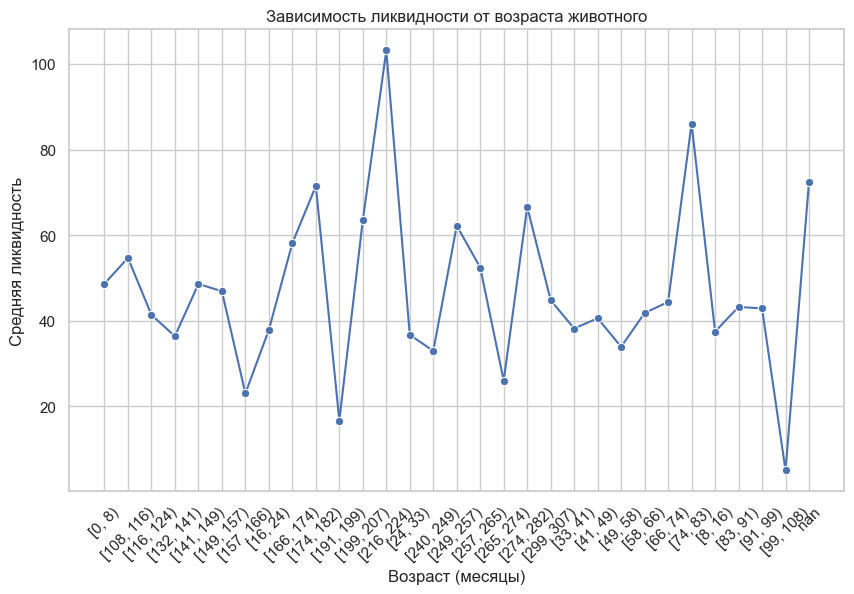

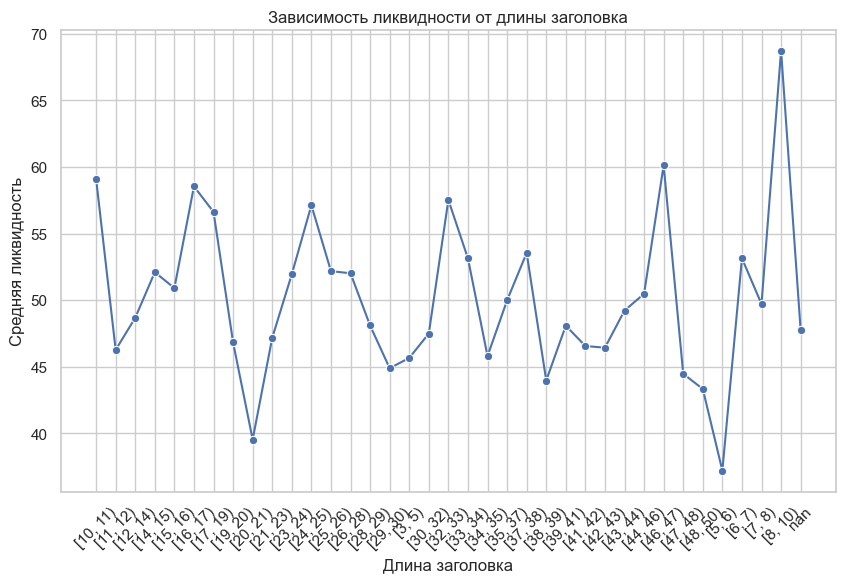

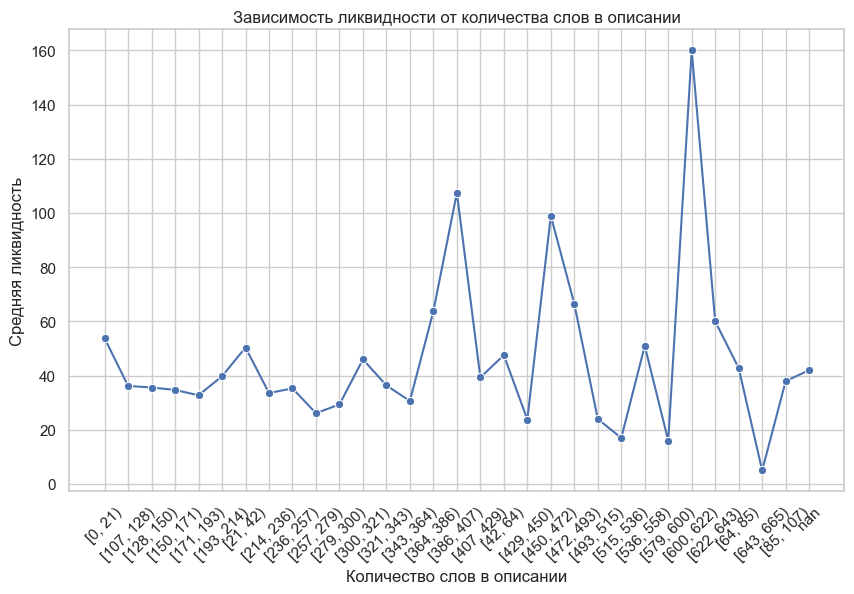

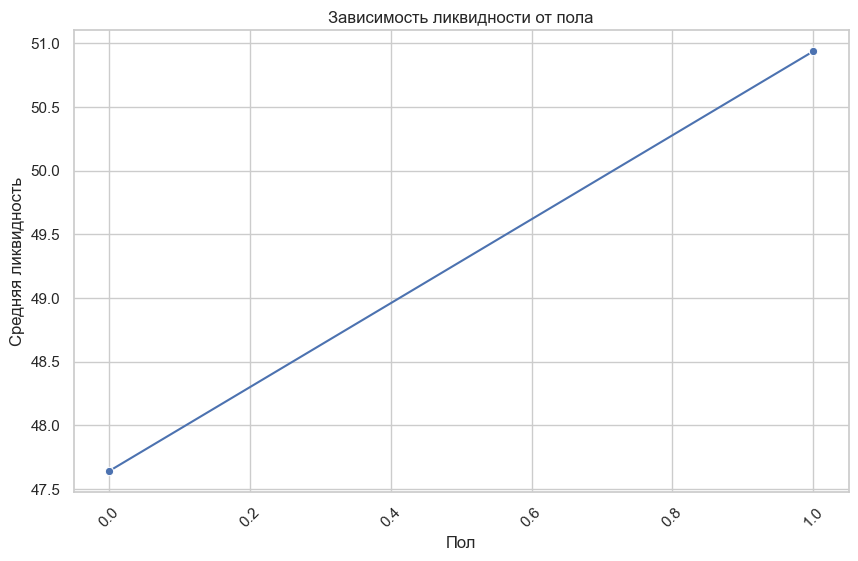

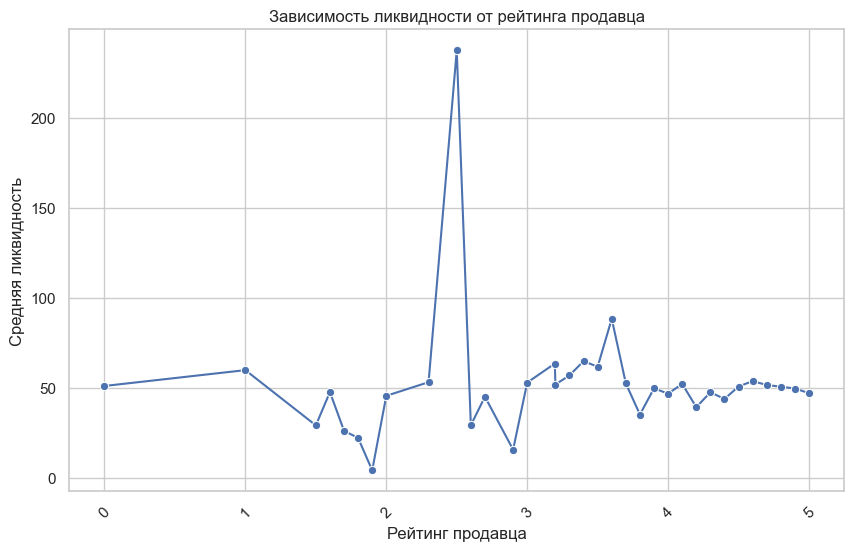

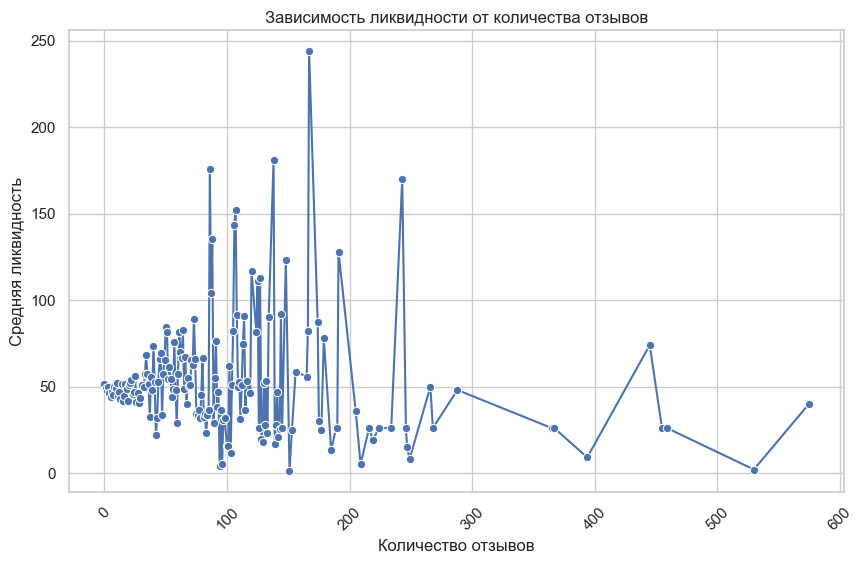

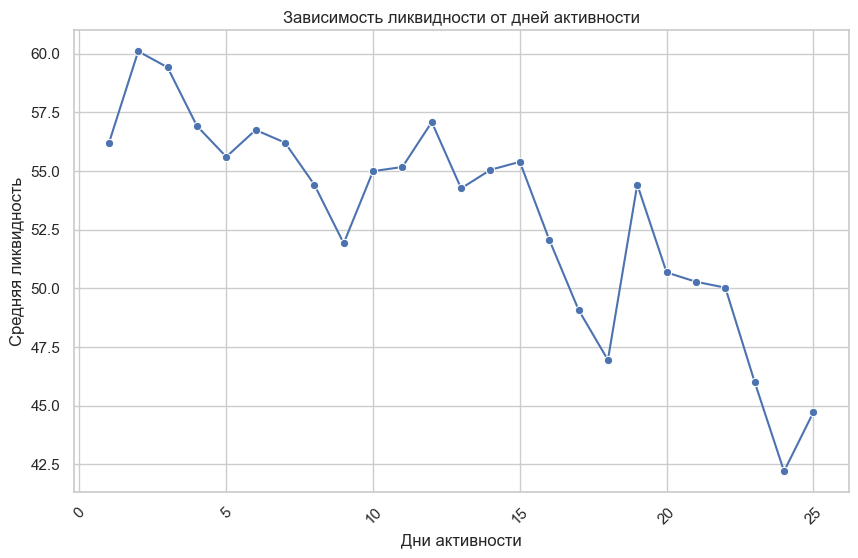

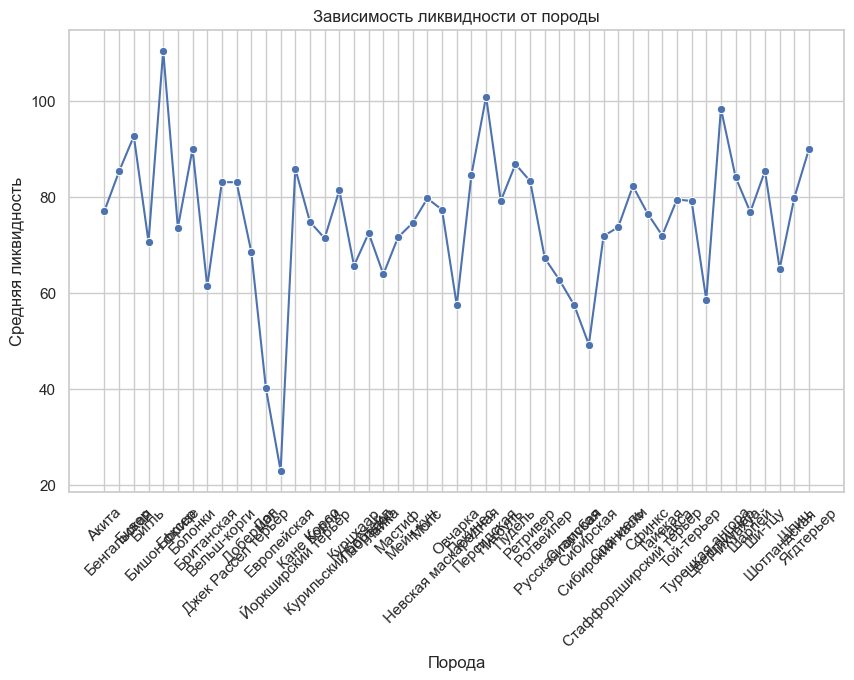

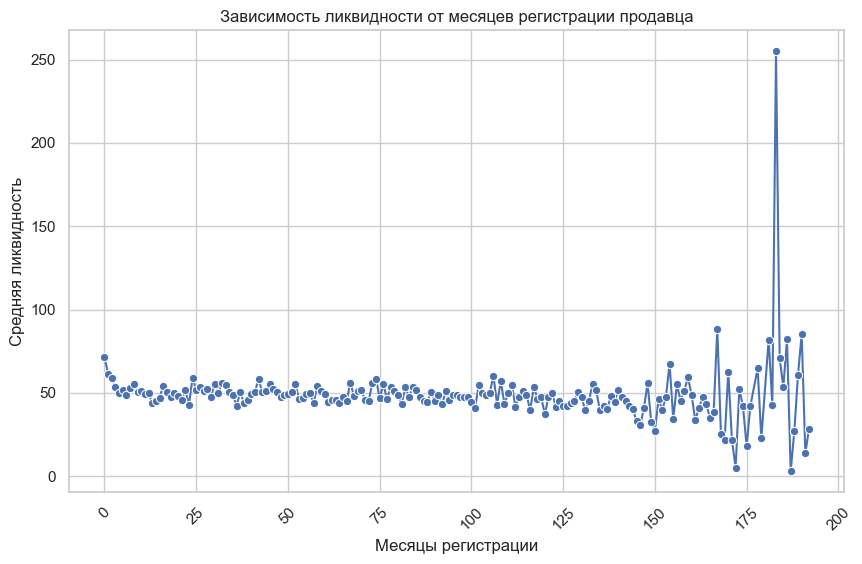

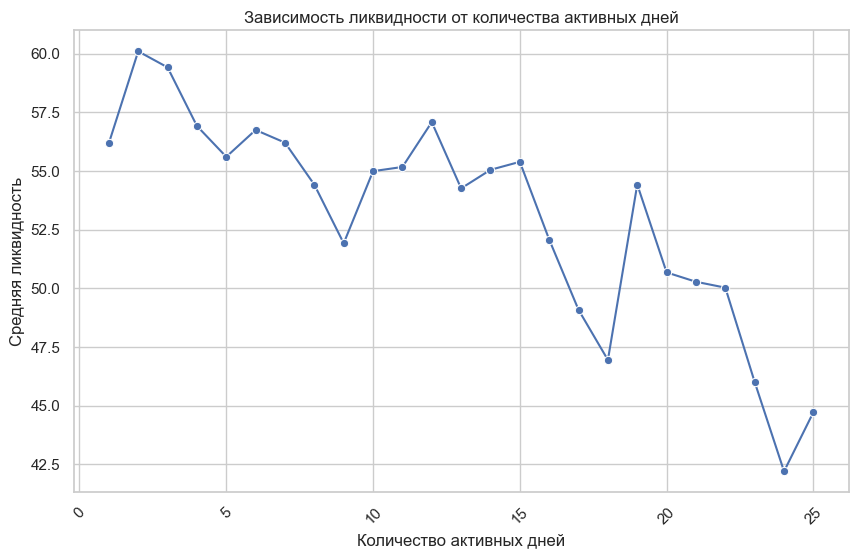

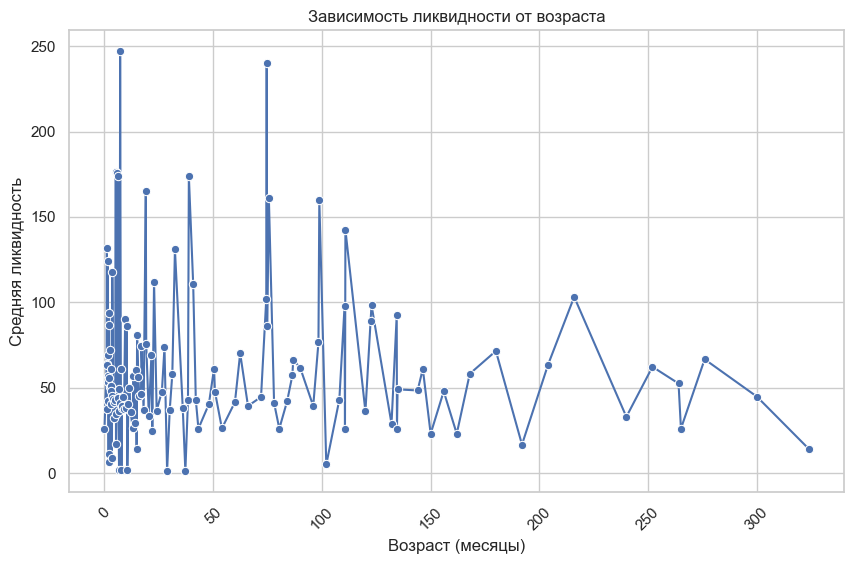

In [48]:
df = data

df['liquidity'] = df['page_views']


sns.set(style="whitegrid")

# Функция для построения линейного графика с медианой
def plot_line(x, y, title, xlabel, ylabel):
    median_data = df.groupby(x)[y].mean().reset_index()  # Группировка и расчет медианы
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=median_data, x=x, y=y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
    plt.show()

def plot_bar(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=x, y=y, estimator=np.median, ci=None)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
    plt.show()

# Функция для определения количества групп
def get_bins(max_value, max_bins=40):
    return list(map(int, np.linspace(0, max_value, min(max_bins, int(max_value) + 1)).tolist()))

# 1. Зависимость ликвидности от цены
price_bins = get_bins(int(df['price'].max()), max_bins=40)
df['price_group'] = pd.cut(df['price'], bins=price_bins, right=False)  # Группировка цен
df['price_group'] = df['price_group'].astype(str)  # Преобразуем в строку для линейного графика
plot_line('price_group', 'liquidity', 'Зависимость ликвидности от цены', 'Цена', 'Средняя ликвидность')

# 2. Зависимость ликвидности от длины описания
description_length_bins = get_bins(df['description_length'].max(), max_bins=40)
df['description_length_group'] = pd.cut(df['description_length'], bins=description_length_bins, right=False).astype(str)  # Группировка длины описания
plot_line('description_length_group', 'liquidity', 'Зависимость ликвидности от длины описания', 'Длина описания', 'Средняя ликвидность')

# 3. Зависимость ликвидности от количества фотографий
plot_line('photo_count', 'liquidity', 'Зависимость ликвидности от количества фотографий', 'Количество фотографий', 'Средняя ликвидность')

# 4. Зависимость ликвидности от наличия видео
plot_line('has_video', 'liquidity', 'Зависимость ликвидности от наличия видео', 'Наличие видео', 'Средняя ликвидность')

# 5. Зависимость ликвидности от возраста животного
age_bins = get_bins(df['age'].max(), max_bins=40)
df['age_group'] = pd.cut(df['age'], bins=age_bins, right=False).astype(str)  # Группировка возраста
plot_line('age_group', 'liquidity', 'Зависимость ликвидности от возраста животного', 'Возраст (месяцы)', 'Средняя ликвидность')

# 6. Зависимость ликвидности от длины заголовка
title_length_bins = get_bins(df['title_length'].max(), max_bins=40)
df['title_length_group'] = pd.cut(df['title_length'], bins=title_length_bins, right=False).astype(str)  # Группировка длины заголовка
plot_line('title_length_group', 'liquidity', 'Зависимость ликвидности от длины заголовка', 'Длина заголовка', 'Средняя ликвидность')

# 7. Зависимость ликвидности от количества слов в описании
description_word_count_bins = get_bins(df['description_word_count'].max(), max_bins=40)
df['description_word_count_group'] = pd.cut(df['description_word_count'], bins=description_word_count_bins, right=False).astype(str)  # Группировка количества слов
plot_line('description_word_count_group', 'liquidity', 'Зависимость ликвидности от количества слов в описании', 'Количество слов в описании', 'Средняя ликвидность')

# 8. Зависимость ликвидности от пола
plot_line('gender', 'liquidity', 'Зависимость ликвидности от пола', 'Пол', 'Средняя ликвидность')

# 9. Зависимость ликвидности от рейтинга продавца
plot_line('seller_rating', 'liquidity', 'Зависимость ликвидности от рейтинга продавца', 'Рейтинг продавца', 'Средняя ликвидность')

# 10. Зависимость ликвидности от количества отзывов
plot_line('seller_count_reviews', 'liquidity', 'Зависимость ликвидности от количества отзывов', 'Количество отзывов', 'Средняя ликвидность')

# 11. Зависимость ликвидности от дней активности
plot_line('days_active', 'liquidity', 'Зависимость ликвидности от дней активности', 'Дни активности', 'Средняя ликвидность')

# 12. Зависимость ликвидности от породы
plot_line('breed', 'liquidity', 'Зависимость ликвидности от породы', 'Порода', 'Средняя ликвидность')

# 13. Зависимость ликвидности от количества дней с момента регистрации продавца
plot_line('seller_n_month', 'liquidity', 'Зависимость ликвидности от месяцев регистрации продавца', 'Месяцы регистрации', 'Средняя ликвидность')

# 14. Зависимость ликвидности от количества активных дней
plot_line('days_active', 'liquidity', 'Зависимость ликвидности от количества активных дней', 'Количество активных дней', 'Средняя ликвидность')

# 15. Зависимость ликвидности от возраста
plot_line('age', 'liquidity', 'Зависимость ликвидности от возраста', 'Возраст (месяцы)', 'Средняя ликвидность')